## Домашнее задание №2
### 2.1 Пользуясь алгоритмом Кросс-Энтропии для конечного пространства действий обучить агента решать Acrobot-v1. Исследовать гиперпараметры алгоритма и выбрать лучшие.

In [1]:
from acrobot import CEMDL
from acrobot import CEMDL_update
from acrobot import main_func
from MountainCar import CEMDL
from MountainCar import MainFunc
import torch
import gym
import matplotlib.pyplot as plt
import numpy as np

In [2]:
env = gym.make('Acrobot-v1')
action_n = 3

In [3]:
agent = CEMDL(action_n, eps=0.0)
rewards_n50_q09 = main_func(env, agent, n_iteration=15, n_trajectories=50, q=0.9)

In [4]:
agent = CEMDL(action_n, eps=0.0)
rewards_n25_q09 = main_func(env, agent, n_iteration=15, n_trajectories=25, q=0.9)

In [5]:
agent = CEMDL(action_n, eps=0.0)
rewards_n10_q09 = main_func(env, agent, n_iteration=15, n_trajectories=10, q=0.9)

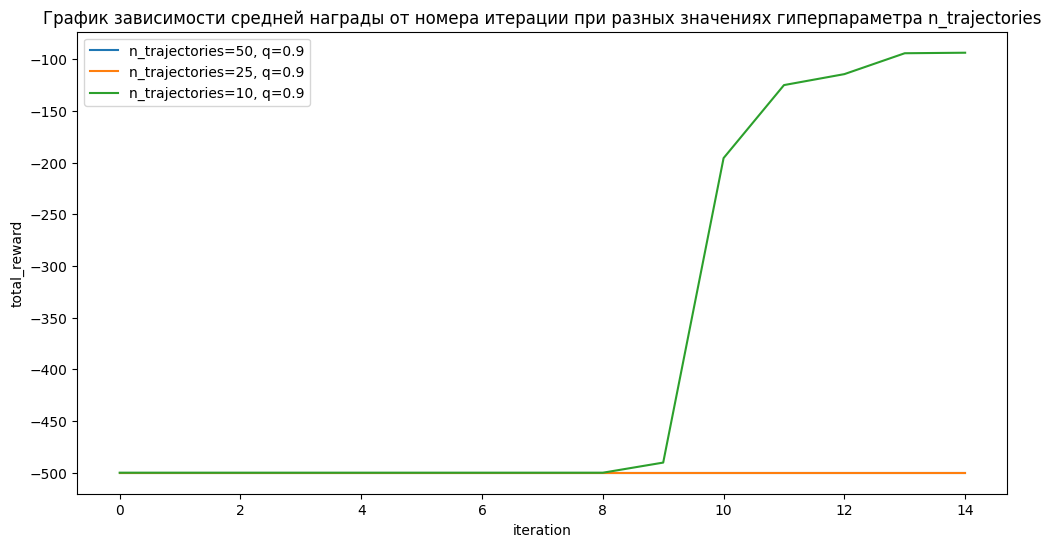

In [6]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(0, 15), rewards_n50_q09, label='n_trajectories=50, q=0.9')
plt.plot(np.arange(0, 15), rewards_n25_q09, label='n_trajectories=25, q=0.9')
plt.plot(np.arange(0, 15), rewards_n10_q09, label='n_trajectories=10, q=0.9')
plt.title('График зависимости средней награды от номера итерации при разных значениях гиперпараметра n_trajectories')
plt.xlabel('iteration')
plt.ylabel('total_reward')
plt.legend()
plt.savefig('plot_n_trajectories.png')
plt.show()

Основная цель этой картинки показать, что алгоритм больше зависит не от количества траекторий (хотя косвенно от него, но лишь потому что чем их больше, тем больше все таки шанс что получится решить задачу хоть у одной), а от начальной инициализации весов (при неудачной инициализации алгоритму так и не удается найти решение и награда остается -500, как показано на картинке выше). Также очевидно необходимость задания маленького значения q - учиться надо на решающих задачу траекториях.

Решением этой проблемы является внедрение параметра eps, который для данной задачи будет означать что действовать по случайной стратегии до первого получения элитных траекторий (вхождении в fit, где он зануляется),а дальше переходить к обучению. Продемострируем что описанный подход работает.

In [3]:
rewards_eps_0 = []
for _ in range(100):
    agent = CEMDL(action_n, eps=0.0)
    rewards_eps_0.append(main_func(env, agent, n_iteration=15, n_trajectories=10, q=0.9)[-1])

In [4]:
rewards_eps_1 = []
for _ in range(100):
    agent = CEMDL(action_n, eps=1.0)
    rewards_eps_1.append(main_func(env, agent, n_iteration=15, n_trajectories=10, q=0.9)[-1])

In [5]:
len_eps_0 = 0
for reward in rewards_eps_0:
    if reward < -490.:
        len_eps_0 += 1
print(f'при отсутствии эпсилон обучение не сошлось в {len_eps_0}%')

при отсутствии эпсилон обучение не сошлось в 41%


In [6]:
len_eps_1 = 0
for reward in rewards_eps_1:
    if reward < -490.:
        len_eps_1 += 1
print(f'при включении эпсилон обучение не сошлось в {len_eps_1}%')

при включении эпсилон обучение не сошлось в 87%


Очень интересный результат: получается, что инициализация рандомных весов нейросети почти в 2 раза лучше равномерного распределения по действиям. Гипотеза, что это является следствием наличия в равномерном распределении действия действия 1 (ничего не делать). Изменим распредление вероятностей действия убрав вариант ничего не делать и проведем тест.

In [3]:
rewards_eps_1_update = []
for _ in range(100):
    agent = CEMDL_update(action_n, eps=1.0)
    rewards_eps_1_update.append(main_func(env, agent, n_iteration=15, n_trajectories=10, q=0.9)[-1])

In [4]:
len_eps_1_update = 0
for reward in rewards_eps_1_update:
    if reward < -490.:
        len_eps_1_update += 1
print(f'при включении изменении равномерной политики (исключении действия "ничего не далать") обучение не сошлось в {len_eps_1_update}%')

при включении изменении равномерной политики (исключении действия "ничего не далать") обучение не сошлось в 10%


### Вывод по заданию 1:
При работе в среде Acrobot-v1 на первый план выходит задача получения хотя бы одного положительного решения задачи, что может достигаться за счет увеличения количества траекторий, введением выполнения задачи равномерной политикий (с учетом отсутствия бездействия) или переинициализацией агента без эпсилон (нового распределения весов) если на нескольких шагах получаем награду -500.

### 2.1 Реализовать алгоритм Кросс-Энтропии для непрерывного пространства действий. Обучить агента решать MountainCarContinuous-v0. Исследовать гиперпараметры алгоритма и выбрать лучшие.

In [12]:
action_left_range = -1.
action_right_range = 1.
env = gym.make('MountainCarContinuous-v0')

agent_cemdl = CEMDL(action_left_range, action_right_range, 1., eps_discount=0.01, lr=0.1)

mainFunc = MainFunc(env, agent_cemdl)

In [13]:
%%time
list_rewards = mainFunc.main_func(n_iteration=100, n_trajectories=100, q=0.0, q_raise=0.1, q_stop=0.7, step_elite=1, visualise=False, is_print=False)

CPU times: user 14min 13s, sys: 500 ms, total: 14min 14s
Wall time: 14min 9s


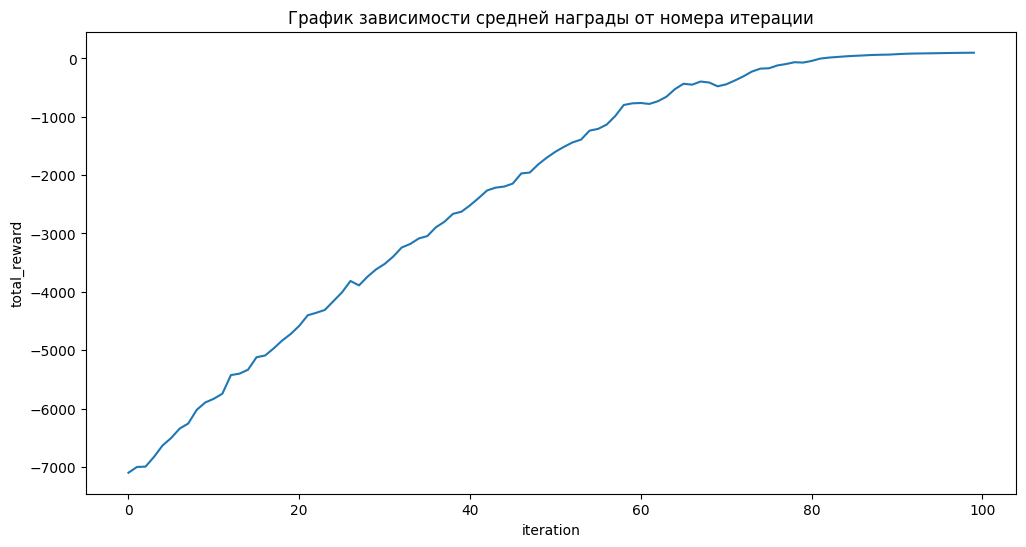

In [15]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(0, 100), list_rewards)
plt.title('График зависимости средней награды от номера итерации')
plt.xlabel('iteration')
plt.ylabel('total_reward')
plt.savefig('plot_mountain_car.png')
plt.show()

### Выводы по заданию 2:
При выполнении задачи было испытано несколько различных подходов в целях ускорения процесса обучения:
* попытка задавать различные виды шума (лучшем образом показал себя синусоидный, который выигрывает со средним значением 91, но при нем остается неисследованным левая часть холма, что по видимому потом является проблемой, потому что модель все равно не может научиться) - остался на обычном юниформе сделав плавное уменьшении eps на всем процессе обучения
* огранизация сохранения отобранных элитных траекторий для использования на нескольких итерациях обучения - в итоге отказался от этой идеи
* постепенное увеличение q от 0 до 0.7 все с той же целью (более жадный сбор элитных траекторий в начале)
* попытки огранизации обучения на процессоре cuda (в нашей задаче становится только хуже)
* попытки обучения на изменных функциях наград с целью вытащить агента из локального минимума "ничего не делать" - в итоге отказался от этой идеи из-за проблем при переходе к целевой функции наград
* увеличение шума: максимальные значения выходящие за границы (-1, 1), чтобы подрезала значения уже среда и было больше больших значений actions
* подбор различных гиперпараметров

В итоге насколько удалось выяснить основные проблемы требующие решения это отбор элитных траекторий и правильная организация шума. На графике продемонстрирован процесс обучения с лучшими параметрами и приемлимым временем обучения для данной задачи.